1. 搭建的神经网络，使用olivettiface数据集进行训练
2. 结合归一化和正则化来优化网络模型结构，观察对比loss结果。

Epoch 1/50, Train Loss: 3.5394, Train Acc: 8.44%, Val Loss: 3.8316, Val Acc: 5.00%
Epoch 2/50, Train Loss: 2.9921, Train Acc: 25.62%, Val Loss: 4.0856, Val Acc: 3.75%
Epoch 3/50, Train Loss: 2.5339, Train Acc: 35.94%, Val Loss: 3.0088, Val Acc: 17.50%
Epoch 4/50, Train Loss: 2.2495, Train Acc: 46.56%, Val Loss: 2.2579, Val Acc: 52.50%
Epoch 5/50, Train Loss: 1.8856, Train Acc: 59.69%, Val Loss: 1.8551, Val Acc: 65.00%
Epoch 6/50, Train Loss: 1.5924, Train Acc: 66.56%, Val Loss: 1.4791, Val Acc: 67.50%
Epoch 7/50, Train Loss: 1.3319, Train Acc: 74.38%, Val Loss: 1.5567, Val Acc: 61.25%
Epoch 8/50, Train Loss: 1.0705, Train Acc: 84.06%, Val Loss: 1.4362, Val Acc: 65.00%
Epoch 9/50, Train Loss: 0.8993, Train Acc: 90.62%, Val Loss: 1.1680, Val Acc: 78.75%
Epoch 10/50, Train Loss: 0.7478, Train Acc: 92.19%, Val Loss: 1.3115, Val Acc: 67.50%
Epoch 11/50, Train Loss: 0.6433, Train Acc: 93.75%, Val Loss: 1.1946, Val Acc: 63.75%
Epoch 12/50, Train Loss: 0.5569, Train Acc: 93.75%, Val Loss: 1.13

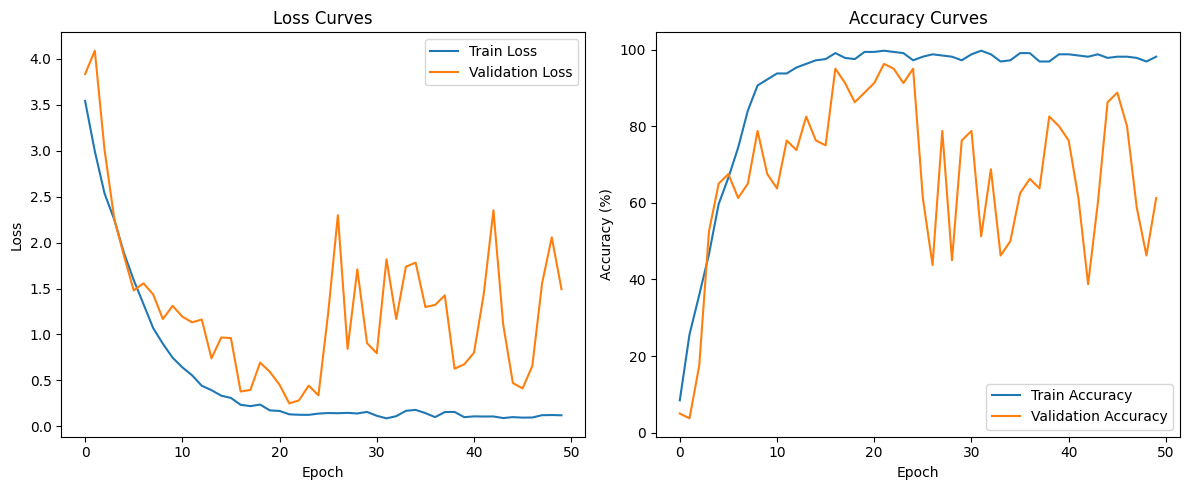

最终测试集上的准确率: 96.25%
最佳验证准确率: 96.25%


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 加载 Olivetti Faces 数据集
faces = fetch_olivetti_faces(shuffle=True)
# 图像数据 X 的形状为 (400, 4096)
X = faces.data
# 标签 y 的值是 0-39，代表 40 个人, 形状为 (400,)
y = faces.target
# print(X.shape, y.shape)

# 数据预处理, test_size 表示测试集占比 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# 转换为 PyTorch 张量
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

# 创建数据加载器
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# 改进的神经网络，使用 olivettiface 数据集进行训练
class My_NN(nn.Module):
    def __init__(self):
        super(My_NN, self).__init__()
        # 添加批 归一化 层(BatchNorm1d) 提高训练稳定性
        self.fc1 = nn.Linear(4096, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 256)
        # self.bn3 = nn.BatchNorm1d(256)
        self.fc4 = nn.Linear(256, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.fc5 = nn.Linear(128, 40)  # 40个类别

        # 正则化：添加 Dropout 层, 缓解过拟合
        # self.dropout = nn.Dropout(0.4)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = x.view(-1, 4096) # 将输入展平
        x = self.bn1(torch.relu(self.fc1(x)))
        x = self.dropout(x)
        x = self.bn2(torch.relu(self.fc2(x)))
        x = self.dropout(x)
        # x = self.bn3(torch.relu(self.fc3(x)))
        x = torch.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.bn4(torch.relu(self.fc4(x)))
        x = self.fc5(x)
        return x


# 初始化模型、损失函数和优化器
model = My_NN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)  # 使用AdamW并添加权重衰减

# 训练模型
num_epochs = 50  # 增加训练轮数
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_accuracy = 0

for epoch in range(num_epochs):
    # 训练阶段
    model.train()
    # 初始化损失和准确率
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        # 步骤1. 前向传播
        outputs = model(inputs)
        # 步骤2. 计算损失
        loss = criterion(outputs, labels)
        # 步骤3. 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # running_loss 表示每个 epoch 的总损失
        running_loss += loss.item()

        # 计算训练准确率
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # 每个 epoch 的平均损失
    train_loss = running_loss / len(train_loader)
    # 计算训练准确率
    train_accuracy = 100 * correct_train / total_train
    # 保存训练损失和准确率
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # 验证阶段
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(test_loader)
    val_losses.append(val_loss)
    accuracy = 100 * correct / total
    val_accuracies.append(accuracy)

    # 保存最佳模型
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), '/Users/chenxing/AI/AiPremiumClass/陈兴/week04/best_olivetti_face_model.pth')

    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {accuracy:.2f}%')

# 绘制训练和验证曲线
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.show()

# 加载最佳模型并在测试集上评估
model.load_state_dict(torch.load('/Users/chenxing/AI/AiPremiumClass/陈兴/week04/best_olivetti_face_model.pth'))
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

final_accuracy = 100 * correct / total
print(f'最终测试集上的准确率: {final_accuracy:.2f}%')
print(f'最佳验证准确率: {best_accuracy:.2f}%')

3. 尝试不同optimizer对模型进行训练，观察对比loss结果。


=== 使用 adam 优化器训练 ===
Epoch 1/20, Train Loss: 3.3195, Train Acc: 14.69%, Val Loss: 4.2327, Val Acc: 5.00%
Epoch 2/20, Train Loss: 2.5138, Train Acc: 45.00%, Val Loss: 4.2882, Val Acc: 7.50%
Epoch 3/20, Train Loss: 2.0272, Train Acc: 57.19%, Val Loss: 3.0509, Val Acc: 18.75%
Epoch 4/20, Train Loss: 1.6770, Train Acc: 67.50%, Val Loss: 2.4634, Val Acc: 36.25%
Epoch 5/20, Train Loss: 1.2884, Train Acc: 76.56%, Val Loss: 1.8579, Val Acc: 56.25%
Epoch 6/20, Train Loss: 1.0487, Train Acc: 82.50%, Val Loss: 1.6838, Val Acc: 60.00%
Epoch 7/20, Train Loss: 0.8568, Train Acc: 88.12%, Val Loss: 1.3434, Val Acc: 73.75%
Epoch 8/20, Train Loss: 0.7758, Train Acc: 88.12%, Val Loss: 1.1087, Val Acc: 82.50%
Epoch 9/20, Train Loss: 0.5849, Train Acc: 95.00%, Val Loss: 1.4328, Val Acc: 63.75%
Epoch 10/20, Train Loss: 0.4768, Train Acc: 95.00%, Val Loss: 1.4388, Val Acc: 58.75%
Epoch 11/20, Train Loss: 0.3822, Train Acc: 97.19%, Val Loss: 1.3238, Val Acc: 73.75%
Epoch 12/20, Train Loss: 0.3110, Train Acc

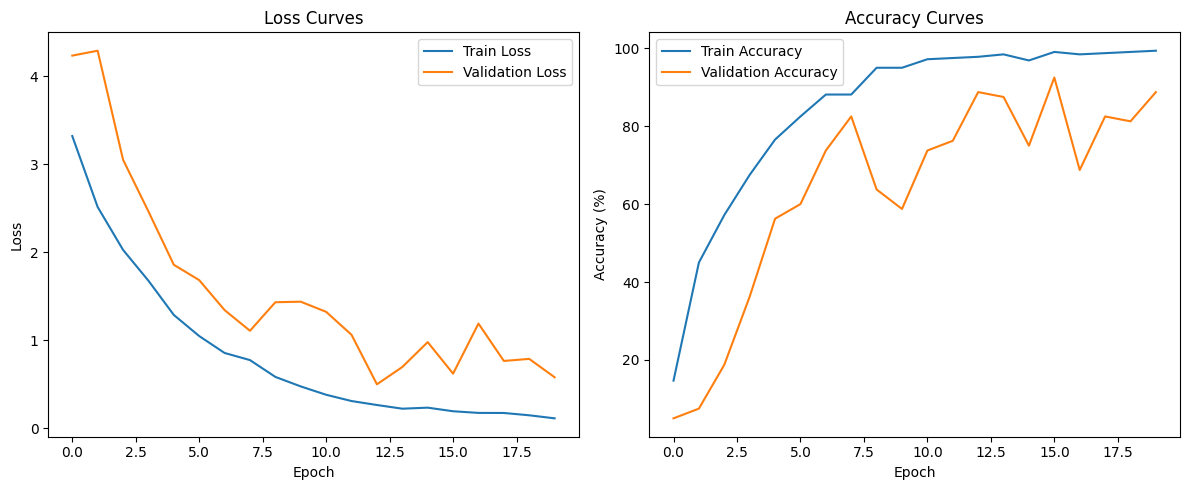


adam 优化器最终测试准确率: 92.50%
adam 优化器最佳验证准确率: 92.50%

=== 使用 adamw 优化器训练 ===
Epoch 1/20, Train Loss: 3.3666, Train Acc: 11.25%, Val Loss: 3.7685, Val Acc: 5.00%
Epoch 2/20, Train Loss: 2.5141, Train Acc: 45.62%, Val Loss: 3.5042, Val Acc: 11.25%
Epoch 3/20, Train Loss: 2.0058, Train Acc: 59.38%, Val Loss: 2.7183, Val Acc: 23.75%
Epoch 4/20, Train Loss: 1.5960, Train Acc: 73.75%, Val Loss: 1.9861, Val Acc: 48.75%
Epoch 5/20, Train Loss: 1.3141, Train Acc: 76.25%, Val Loss: 1.6454, Val Acc: 61.25%
Epoch 6/20, Train Loss: 1.0111, Train Acc: 84.06%, Val Loss: 1.4017, Val Acc: 66.25%
Epoch 7/20, Train Loss: 0.7551, Train Acc: 93.44%, Val Loss: 1.4352, Val Acc: 66.25%
Epoch 8/20, Train Loss: 0.6321, Train Acc: 92.81%, Val Loss: 1.0687, Val Acc: 85.00%
Epoch 9/20, Train Loss: 0.4765, Train Acc: 95.94%, Val Loss: 1.2104, Val Acc: 75.00%
Epoch 10/20, Train Loss: 0.3916, Train Acc: 98.44%, Val Loss: 0.7214, Val Acc: 95.00%
Epoch 11/20, Train Loss: 0.3012, Train Acc: 98.75%, Val Loss: 0.7985, Val Acc

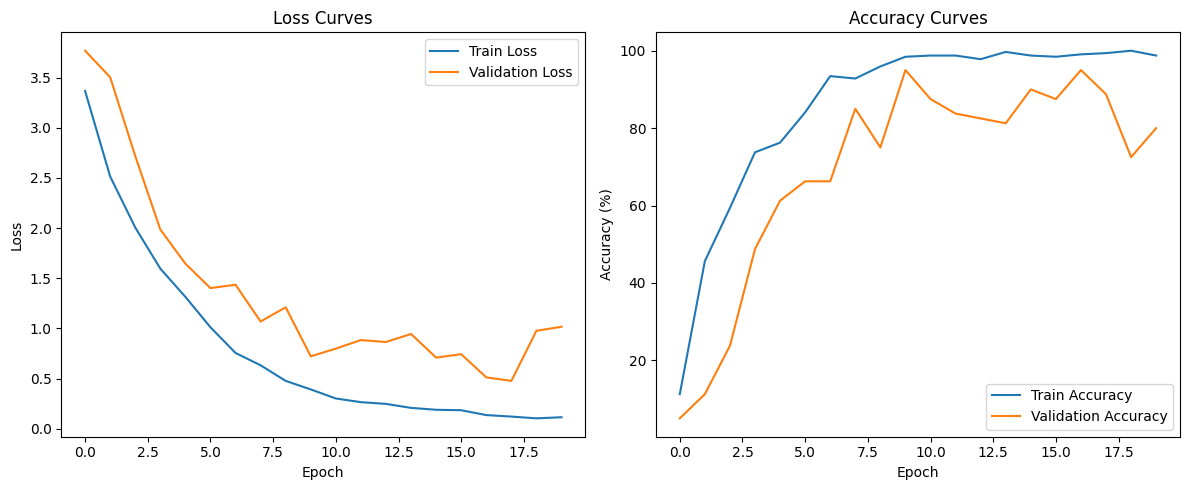


adamw 优化器最终测试准确率: 95.00%
adamw 优化器最佳验证准确率: 95.00%

=== 使用 sgd 优化器训练 ===
Epoch 1/20, Train Loss: 3.6853, Train Acc: 5.62%, Val Loss: 3.6844, Val Acc: 2.50%
Epoch 2/20, Train Loss: 3.0593, Train Acc: 21.25%, Val Loss: 3.5406, Val Acc: 6.25%
Epoch 3/20, Train Loss: 2.5823, Train Acc: 52.50%, Val Loss: 3.1804, Val Acc: 33.75%
Epoch 4/20, Train Loss: 2.2449, Train Acc: 67.81%, Val Loss: 2.7240, Val Acc: 52.50%
Epoch 5/20, Train Loss: 1.9945, Train Acc: 74.38%, Val Loss: 2.3948, Val Acc: 72.50%
Epoch 6/20, Train Loss: 1.7917, Train Acc: 75.94%, Val Loss: 2.0772, Val Acc: 68.75%
Epoch 7/20, Train Loss: 1.5643, Train Acc: 87.19%, Val Loss: 2.0261, Val Acc: 75.00%
Epoch 8/20, Train Loss: 1.4453, Train Acc: 88.12%, Val Loss: 1.8631, Val Acc: 73.75%
Epoch 9/20, Train Loss: 1.2738, Train Acc: 91.56%, Val Loss: 1.7573, Val Acc: 72.50%
Epoch 10/20, Train Loss: 1.1555, Train Acc: 94.06%, Val Loss: 1.6969, Val Acc: 78.75%
Epoch 11/20, Train Loss: 1.0529, Train Acc: 94.38%, Val Loss: 1.5189, Val Acc: 

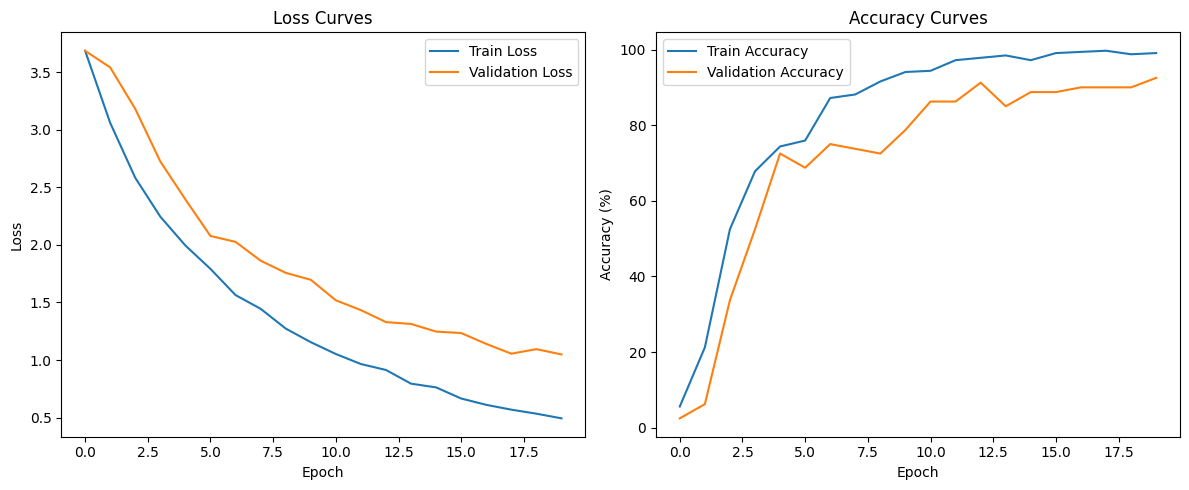


sgd 优化器最终测试准确率: 92.50%
sgd 优化器最佳验证准确率: 92.50%


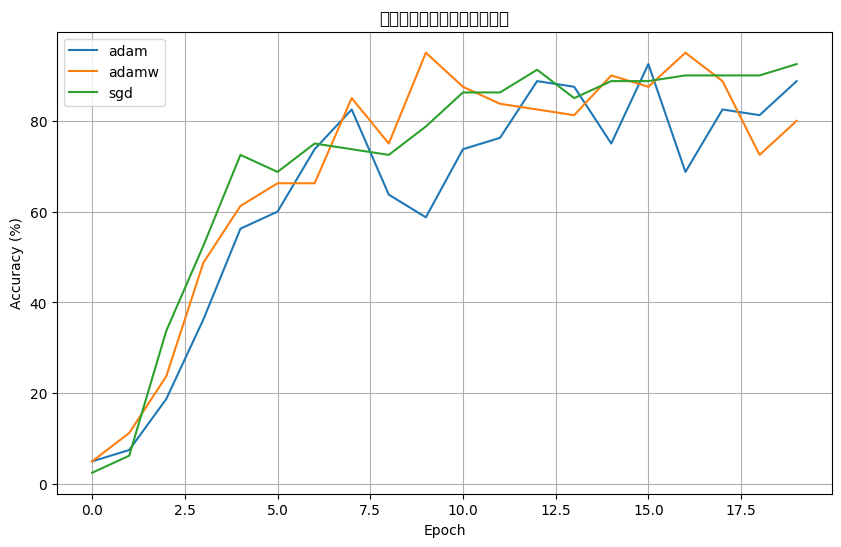


=== 不同优化器性能比较 ===
adam: 最终准确率 92.50%, 最佳准确率 92.50%
adamw: 最终准确率 95.00%, 最佳准确率 95.00%
sgd: 最终准确率 92.50%, 最佳准确率 92.50%


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# 改进的神经网络，使用 olivettiface 数据集进行训练
class Improved_NN(nn.Module):
    def __init__(self):
        super(Improved_NN, self).__init__()
        # 添加批归一化层(BatchNorm1d)提高训练稳定性
        self.fc1 = nn.Linear(4096, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.fc4 = nn.Linear(256, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.fc5 = nn.Linear(128, 40)  # 40个类别

        # 正则化：添加 Dropout 层, 缓解过拟合
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = x.view(-1, 4096)
        x = self.bn1(torch.relu(self.fc1(x)))
        x = self.dropout(x)
        x = self.bn2(torch.relu(self.fc2(x)))
        x = self.dropout(x)
        x = self.bn3(torch.relu(self.fc3(x)))
        x = self.dropout(x)
        x = self.bn4(torch.relu(self.fc4(x)))
        x = self.fc5(x)
        return x

# 数据加载函数
def load_olivetti_data(test_size=0.2, random_state=42):
    # 加载 Olivetti Faces 数据集
    faces = fetch_olivetti_faces(shuffle=True)
    X = faces.data  # 图像数据，形状为 (400, 4096)
    y = faces.target  # 标签，形状为 (400,)，取值范围 0-39

    # 数据预处理
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # 转换为 PyTorch 张量
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.LongTensor(y_train)
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.LongTensor(y_test)

    # 创建数据加载器
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    return train_loader, test_loader, X_test, y_test

# 训练函数
def train_model(model, train_loader, test_loader, optimizer_name='adamw', lr=0.001, weight_decay=1e-4, 
                num_epochs=50, model_path='/Users/chenxing/AI/AiPremiumClass/陈兴/week04/best_model.pth'):
    """
    训练神经网络模型
    
    参数:
        model: 神经网络模型
        train_loader: 训练数据加载器
        test_loader: 测试数据加载器
        optimizer_name: 优化器名称，可选 'adam', 'adamw', 'sgd', 'rmsprop'
        lr: 学习率
        weight_decay: 权重衰减系数
        num_epochs: 训练轮数
        model_path: 模型保存路径
        
    返回:
        训练历史记录和最佳准确率
    """
    # 初始化损失函数
    criterion = nn.CrossEntropyLoss()
    
    # 根据参数选择优化器
    if optimizer_name.lower() == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name.lower() == 'adamw':
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name.lower() == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    elif optimizer_name.lower() == 'rmsprop':
        optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        raise ValueError(f"不支持的优化器: {optimizer_name}")
    
    # 记录训练历史
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }
    
    best_accuracy = 0
    
    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for inputs, labels in train_loader:
            # 前向传播
            outputs = model(inputs)
            # 计算损失
            loss = criterion(outputs, labels)
            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            # 计算训练准确率
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_accuracy)
        
        # 验证阶段
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(test_loader)
        accuracy = 100 * correct / total
        history['val_loss'].append(val_loss)
        history['val_acc'].append(accuracy)
        
        # 保存最佳模型
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), model_path)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {accuracy:.2f}%')
    
    return history, best_accuracy

# 评估函数
def evaluate_model(model, test_loader, model_path):
    """评估模型性能"""
    # 加载最佳模型
    model.load_state_dict(torch.load(model_path))
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    final_accuracy = 100 * correct / total
    return final_accuracy

# 可视化训练历史
def plot_history(history):
    """绘制训练和验证曲线"""
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.tight_layout()
    plt.show()


# 主函数：比较不同优化器
def compare_optimizers(optimizers=['adam', 'adamw', 'sgd', 'rmsprop'], num_epochs=30):
    """比较不同优化器的性能"""
    # 加载数据
    train_loader, test_loader, X_test, y_test = load_olivetti_data()
    
    results = {}
    
    for opt_name in optimizers:
        print(f"\n=== 使用 {opt_name} 优化器训练 ===")
        
        # 初始化模型
        model = Improved_NN()
        
        # 设置模型保存路径
        model_path = f'/Users/chenxing/AI/AiPremiumClass/陈兴/week04/best_{opt_name}_model.pth'
        
        # 训练模型
        history, best_acc = train_model(
            model=model,
            train_loader=train_loader,
            test_loader=test_loader,
            optimizer_name=opt_name,
            num_epochs=num_epochs,
            model_path=model_path
        )
        
        # 评估模型
        final_acc = evaluate_model(model, test_loader, model_path)
        
        # 可视化训练历史
        plot_history(history)
        
        # 保存结果
        results[opt_name] = {
            'best_accuracy': best_acc,
            'final_accuracy': final_acc,
            'history': history
        }
        
        print(f"\n{opt_name} 优化器最终测试准确率: {final_acc:.2f}%")
        print(f"{opt_name} 优化器最佳验证准确率: {best_acc:.2f}%")
    
    # 比较不同优化器的结果
    plt.figure(figsize=(10, 6))
    for opt_name in optimizers:
        plt.plot(results[opt_name]['history']['val_acc'], label=f'{opt_name}')
    plt.title('不同优化器的验证准确率比较')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # 打印最终结果比较
    print("\n=== 不同优化器性能比较 ===")
    for opt_name in optimizers:
        print(f"{opt_name}: 最终准确率 {results[opt_name]['final_accuracy']:.2f}%, 最佳准确率 {results[opt_name]['best_accuracy']:.2f}%")
    
    return results

# 使用示例
if __name__ == "__main__":
    # 比较不同优化器
    compare_optimizers(['adam', 'adamw', 'sgd'], num_epochs=20)
    
    # 或者单独训练一个模型
    # train_loader, test_loader, X_test, y_test = load_olivetti_data()
    # model = Improved_NN()
    # history, best_acc = train_model(
    #     model=model,
    #     train_loader=train_loader,
    #     test_loader=test_loader,
    #     optimizer_name='adam',  # 可以修改为其他优化器
    #     num_epochs=50
    # )
    # final_acc = evaluate_model(model, test_loader, '/Users/chenxing/AI/AiPremiumClass/陈兴/week04/best_model.pth')
    # plot_history(history)
    # print(f'最终测试集上的准确率: {final_acc:.2f}%')
    # print(f'最佳验证准确率: {best_acc:.2f}%')